In [1]:
import pandas as pd
import numpy as np

from pandas.api.types import CategoricalDtype
from src.eda_methods import show_barplot

In [2]:
# temporarily loads data for all commits
tmp = pd.read_csv('assets/data/accumulo/accumulo_commits.csv', header=None, nrows=500)

# transforms date column into datetime_index
all_commits = pd.Series(tmp[0].values, index=tmp[1].values)
all_commits.index = pd.to_datetime(all_commits.index, infer_datetime_format=True)

# removes temporary dataframe
del tmp

# loads data for cochange count of each commit
cochange_df =\
    pd.read_csv(
        'assets/data/accumulo/accumulo-cochange.mdg',
        header=None,
        nrows=500,
        sep='\t'
    )[[2,3,6]]\
    .rename(
        columns={2: 'support_count', 3: 'confidence', 6: 'commit_hash'}
    )

# transforms support_count into an ordinal categorical variable 
cochange_df.support_count =\
    cochange_df.support_count.astype(
        CategoricalDtype(categories=np.unique(
            cochange_df.support_count.values),
            ordered=True
        )
    )

In [3]:
# cochange_df['commit_hash'].apply(lambda x: x in all_commits.values).describe()

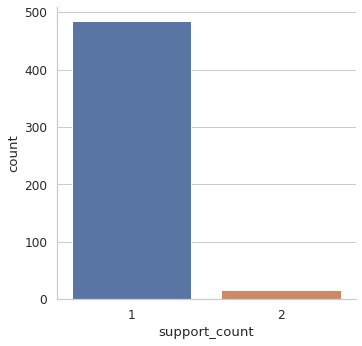

In [5]:
show_barplot(cochange_df, 'support_count')